In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Import data

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list,sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

In [7]:
curr_storms

,Array,Chunk
Bytes,518.99 MiB,102.52 kiB
Shape,"(3, 1, 48, 36, 4, 81, 81)","(1, 1, 1, 1, 4, 81, 81)"
Count,65239 Tasks,5184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,518.99 MiB,102.52 kiB
Shape,"(3, 1, 48, 36, 4, 81, 81)","(1, 1, 1, 1, 4, 81, 81)"
Count,65239 Tasks,5184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Pressure surface lagrangians

## Specific humidity at 850hPa

/tmp/user/27529/ipykernel_342182/3635654153.py:17: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_342182/3635654153.py:18: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_342182/3635654153.py:19: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_342182/3635654153.py:20: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_ylabel('lat from storm centre')
/tmp/user/27529/ipykernel_342182/3635654153.py:21: DeprecationWarning: self.axes is deprecated si

Text(666.5032679738563, 0.5, 'lat from storm centre')

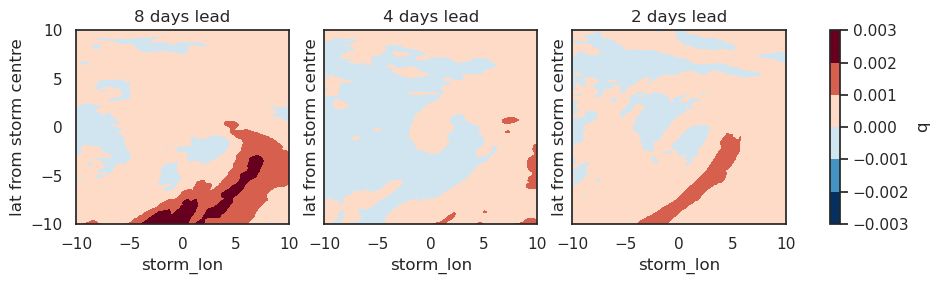

In [8]:
lev = 850
cplot = (incr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
# z_min = 11000
# z_max = 1500
# longitude = incr_storms.storm_lon.values
# latitude = incr_storms.storm_lat.values
# for i in range(0,2):
#     z_vals = curr_storms.z.sel(timestep=0, level=lev).mean('number').squeeze().sortby('inidate').values
#     clevs_p = np.linspace(z_min, z_max, 17) 
#     cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
#     plt.clabel(cs, fmt='%d')
#     cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

In [10]:
incr_storms.q.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze()

<xarray.DataArray 'q' (storm_lat: 81, storm_lon: 81)>
dask.array<getitem, shape=(81, 81), dtype=float32, chunksize=(81, 81), chunktype=numpy.ndarray>
Coordinates:
  * storm_lon   (storm_lon) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * storm_lat   (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
    level       int32 850
    timestep    float64 0.0
    experiment  <U4 'incr'
    inidate     datetime64[ns] 2022-02-16

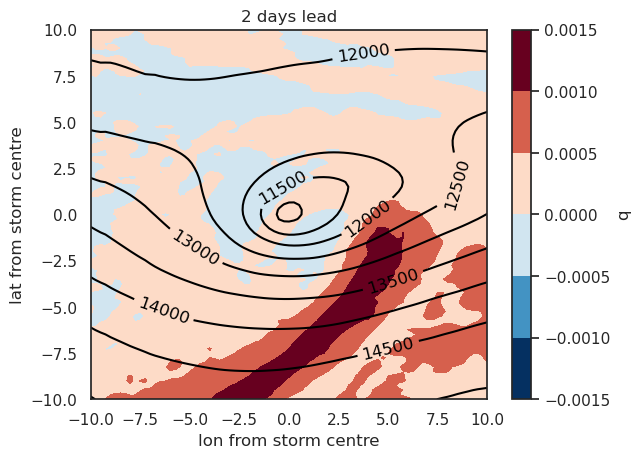

In [19]:
lev = 850
cplot = (incr_storms.q.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze()).plot.contourf()
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze().values
clevs_p = np.linspace(z_min, z_max, 11) 
cs = cplot.axes.contour(longitude, latitude, z_vals, clevs_p, colors='black')
plt.clabel(cs, fmt='%d')

# titles etc
cplot.axes.set_title('2 days lead')
cplot.axes.set_ylabel('lat from storm centre')
cplot.axes.set_xlabel('lon from storm centre')

plt.savefig('figures/11_poster_q_2022-02-16.png')
plt.savefig('figures/11_poster_q_2022-02-16.pdf')

/tmp/user/27529/ipykernel_809275/1724406886.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/1724406886.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/1724406886.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/1724406886.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/1724406886.py:8: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

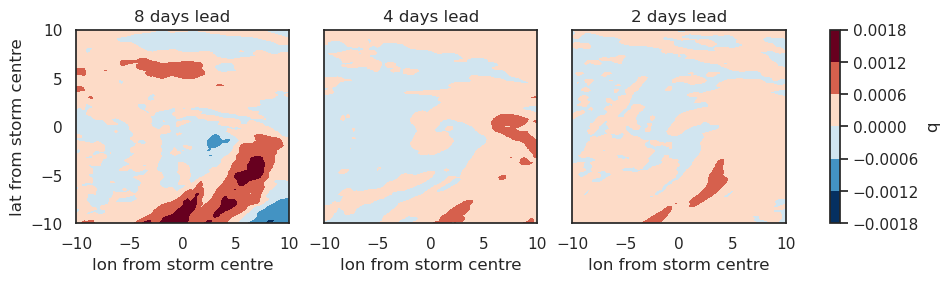

In [8]:
cplot = (curr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').sortby('inidate').squeeze()).plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Specific humidity at 500hPa

/tmp/user/27529/ipykernel_809275/3748764006.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/3748764006.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/3748764006.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/3748764006.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/3748764006.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

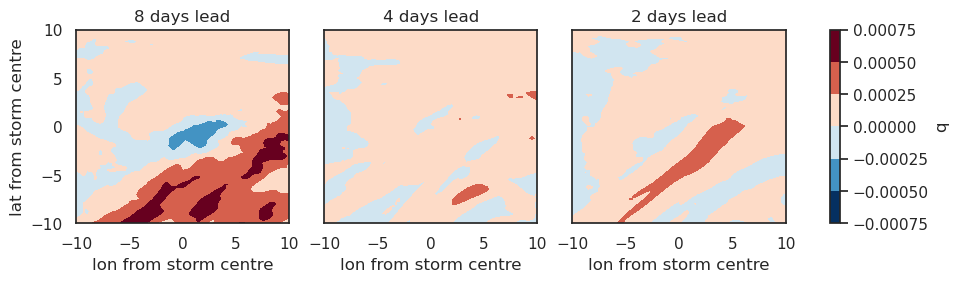

In [9]:
lev = 500
cplot = (incr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

/tmp/user/27529/ipykernel_809275/3862503375.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/3862503375.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/3862503375.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/3862503375.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/3862503375.py:8: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

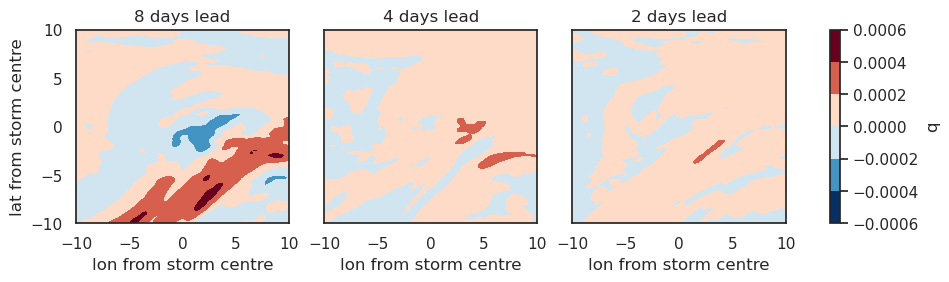

In [10]:
cplot = (curr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Relative humidity at 850hPa

/tmp/user/27529/ipykernel_809275/589725551.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/589725551.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/589725551.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/589725551.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/589725551.py:10: DeprecationWarning: self.axes is deprecated since 2022.

Text(74.0, 0.5, 'lat from storm centre')

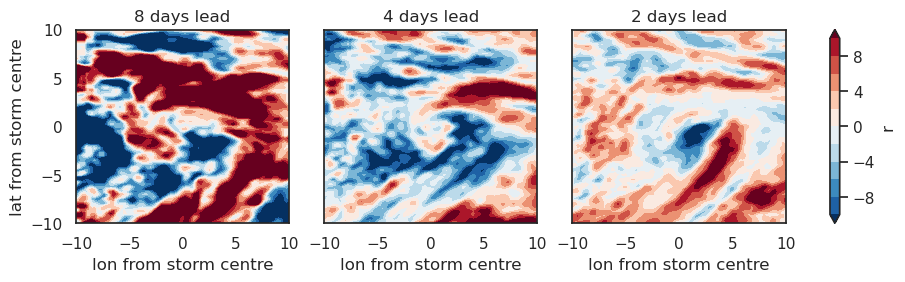

In [11]:
lev = 850
cplot = (incr_storms.r.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.r.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-10,10,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

/tmp/user/27529/ipykernel_809275/2705774218.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/2705774218.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/2705774218.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/2705774218.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/2705774218.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

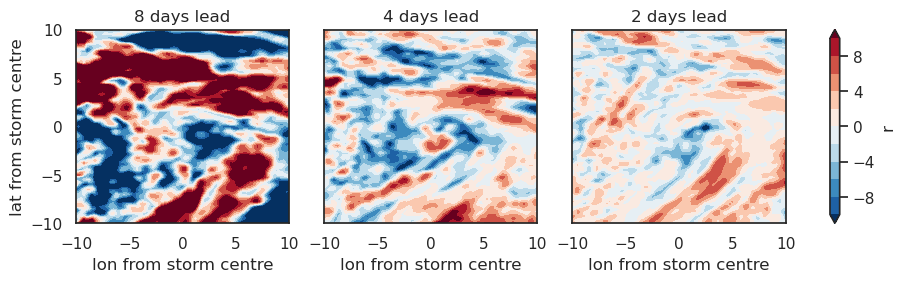

In [12]:
cplot = (curr_storms.r.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.r.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-10,10,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Vertical velocity at 850hPa

/tmp/user/27529/ipykernel_809275/2677097258.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/2677097258.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/2677097258.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/2677097258.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/2677097258.py:10: DeprecationWarning: self.axes is deprecated since 

Text(74.0, 0.5, 'lat from storm centre')

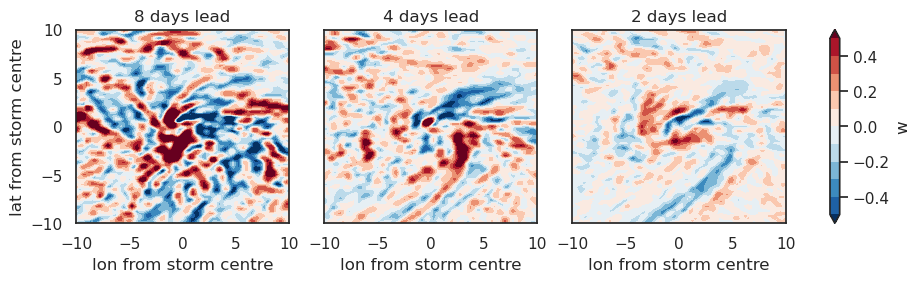

In [13]:
lev = 850
cplot = (incr_storms.w.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.w.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-0.5,0.5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

/tmp/user/27529/ipykernel_809275/919572997.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/919572997.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/919572997.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/919572997.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/919572997.py:9: DeprecationWarning: self.axes is deprecated since 2022.1

Text(74.0, 0.5, 'lat from storm centre')

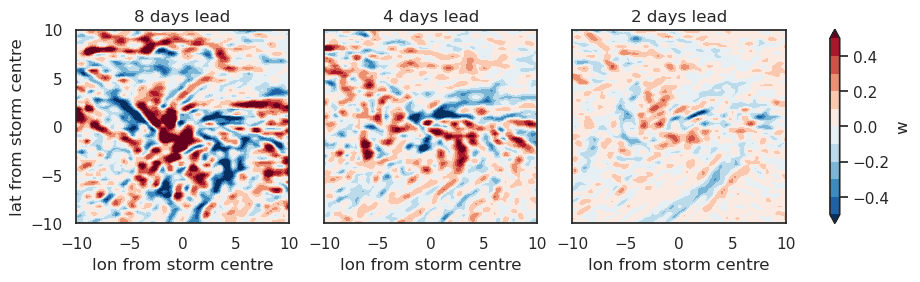

In [14]:
cplot = (curr_storms.w.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.w.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-0.5,0.5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

### No difference, current climate vertical velocity

/tmp/user/27529/ipykernel_809275/1313681609.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/1313681609.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/1313681609.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/1313681609.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/1313681609.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

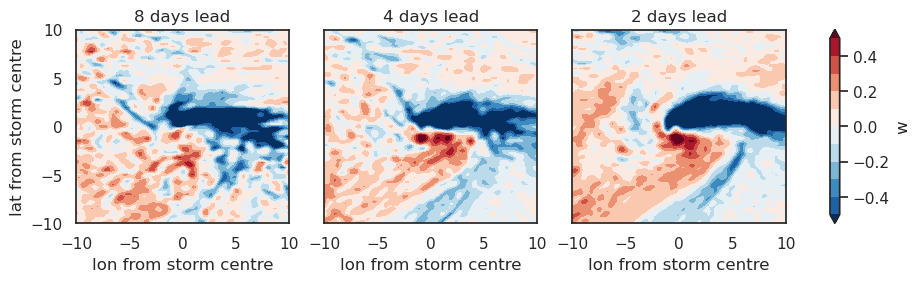

In [15]:
lev = 850
cplot = (curr_storms.w.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate', levels=np.linspace(-0.5,0.5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Vorticity at 850hPa

/tmp/user/27529/ipykernel_809275/1018616192.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/1018616192.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/1018616192.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/1018616192.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/1018616192.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

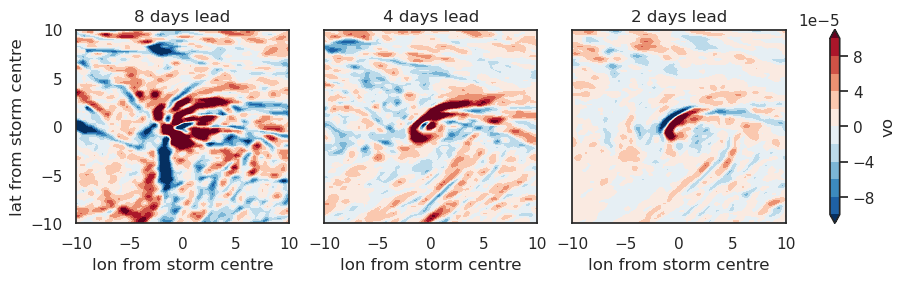

In [16]:
lev = 850
cplot = (incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                                                levels=np.linspace(-0.0001, 0.0001,11))
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Vorticity at 500hPa

/tmp/user/27529/ipykernel_809275/1765628536.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/1765628536.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/1765628536.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/1765628536.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/1765628536.py:10: DeprecationWarning: self.axes is deprecated since 

Text(74.0, 0.5, 'lat from storm centre')

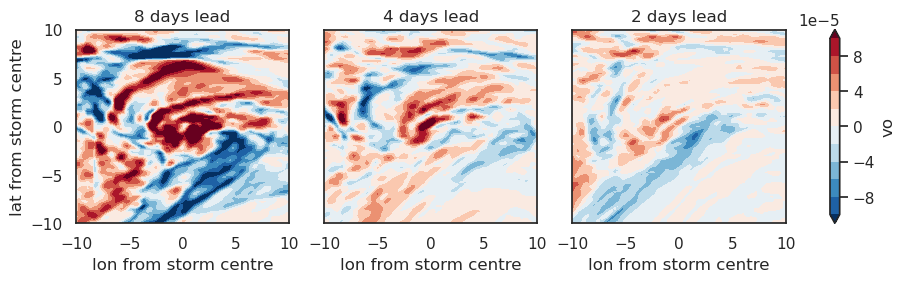

In [18]:
lev = 500
cplot =(incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                      levels=np.linspace(-0.0001, 0.0001,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Vorticity at 250hPa

/tmp/user/27529/ipykernel_809275/2284617425.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/2284617425.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/2284617425.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/2284617425.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/2284617425.py:10: DeprecationWarning: self.axes is deprecated since 

Text(74.0, 0.5, 'lat from storm centre')

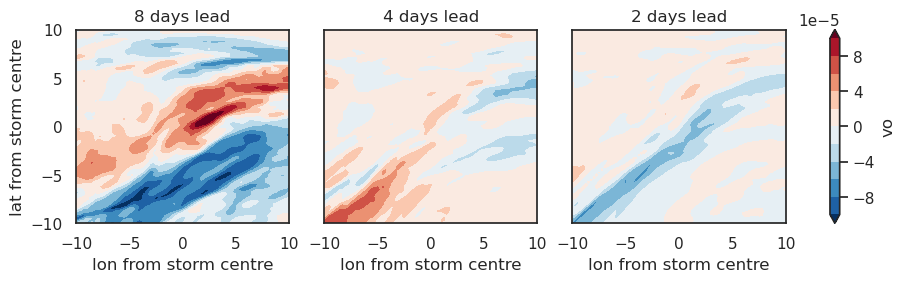

In [20]:
lev = 250
cplot =(incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                      levels=np.linspace(-0.0001, 0.0001,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Temperature at 850 hPa

/tmp/user/27529/ipykernel_809275/15554827.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/15554827.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/15554827.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/15554827.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/15554827.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in 

Text(74.0, 0.5, 'lat from storm centre')

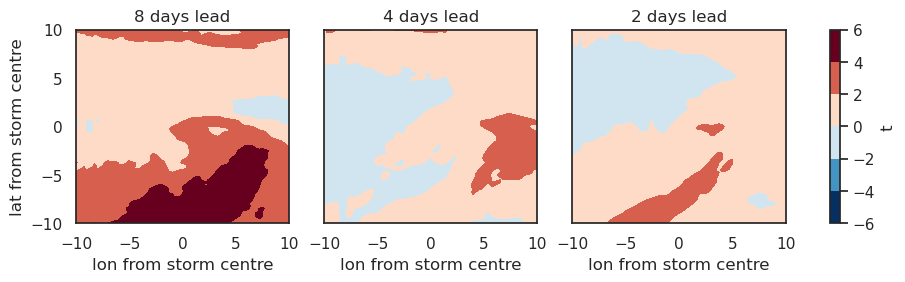

In [22]:
lev = 850
cplot =(incr_storms.t.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.t.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Temperature at 500 hPa

/tmp/user/27529/ipykernel_809275/2602657725.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/2602657725.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/2602657725.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/2602657725.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/2602657725.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

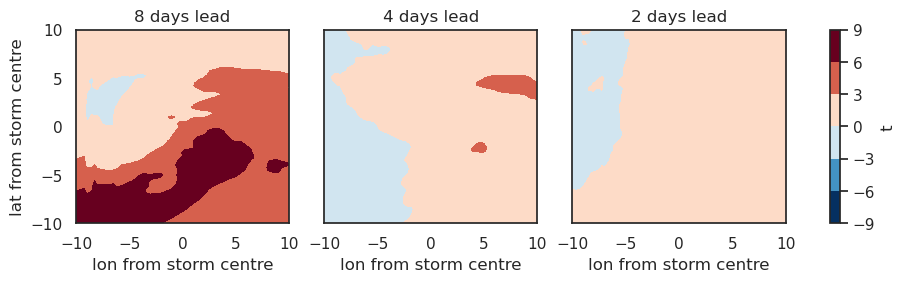

In [23]:
lev = 500
cplot =(incr_storms.t.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.t.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Temperature at 250 hPa

/tmp/user/27529/ipykernel_809275/2592019995.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/2592019995.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/2592019995.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/2592019995.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/2592019995.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

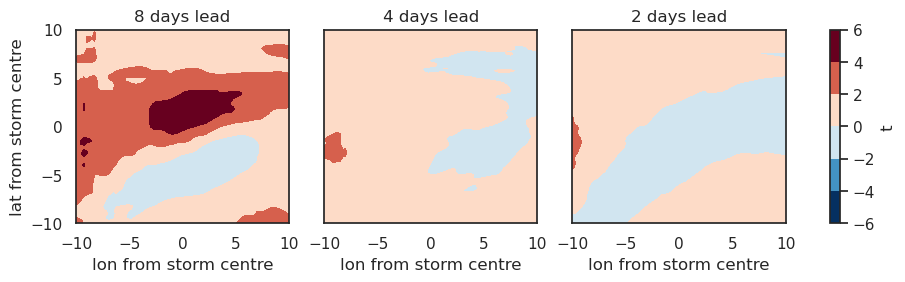

In [24]:
lev =250
cplot =(incr_storms.t.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.t.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')

## Divergence at 250 hPa

/tmp/user/27529/ipykernel_809275/3838769637.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/3838769637.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/3838769637.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/3838769637.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/3838769637.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

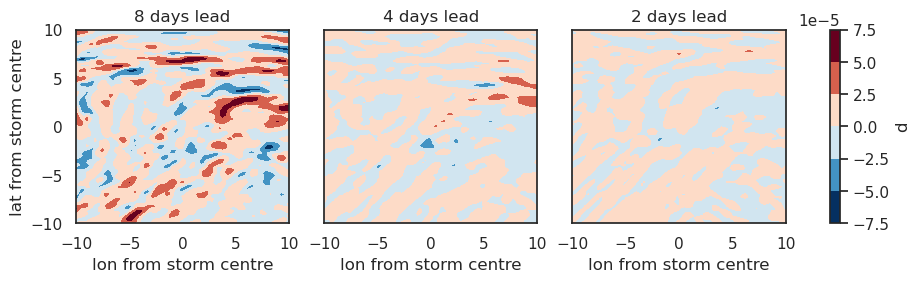

In [25]:
lev =250
cplot =(incr_storms.d.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.d.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')